# M12 Seminar: Economic and Social Problems: Insights from Big Data.
# Term Paper. 
# Replication file №2 - initial hotspot analysis (regressions)

### Imports

In [33]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings('ignore')

### US Data - no controls
### Original files can be found [here](https://github.com/social-connectedness-index/example-scripts)

In [52]:
# load SCI data
us_sci_covariates = pd.read_csv('covid19_exploration/_intermediate/westchester_sci_covariates.csv', 
                                encoding='cp1251')
# filter out close counties
print(f'Old minimum distance to the early hotspot = {np.round(us_sci_covariates.dist.min())}')
us_sci_covariates = us_sci_covariates.loc[us_sci_covariates['dist'] > 50.0]
print(f'New minimum distance to the early hotspot = {np.round(us_sci_covariates.dist.min())}')
us_sci_covariates = us_sci_covariates.sort_values(by='sci', ascending=False).reset_index(drop=True)
# take logs of SCI
us_sci_covariates['log_sci'] = np.log(us_sci_covariates['sci'])

Old minimum distance to the early hotspot = 15.0
New minimum distance to the early hotspot = 51.0


In [54]:
# top 10 US counties by SCI to Westchester County, New York (distance to the hotspot > 50 miles)
us_sci_covariates[['label', 'sci', 'cases_per_10k']].head(10)

,label,sci,cases_per_10k
0,"Ulster County, New York",47850,10.547996
1,"Nantucket County, Massachusetts",39593,0.000000
2,"Sullivan County, New York",36660,13.327527
3,"Columbia County, New York",30340,5.855468
4,"Dukes County, Massachusetts",29223,0.000000
5,"Greene County, New York",28646,2.092444
6,"Suffolk County, New York",28409,38.668665
7,"Litchfield County, Connecticut",28119,6.126189
8,"Albany County, New York",24884,7.032212
9,"Pike County, Pennsylvania",22811,7.003430


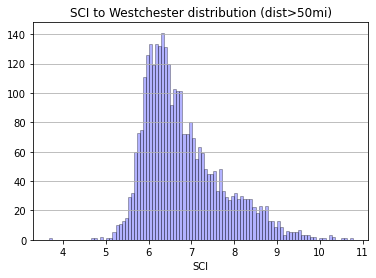

In [55]:
# plot the distribution of SCI across counties
plt.hist(us_sci_covariates['log_sci'], bins=100, color='blue', alpha=0.3, ec='black')
plt.grid(axis='y')
plt.title('SCI to Westchester distribution (dist>50mi)')
plt.xlabel('SCI')
plt.show()

In [56]:
# group log(SCI) into 100 equal-sized bins
bins = pd.cut(x=us_sci_covariates['log_sci'], bins=100, precision=3)

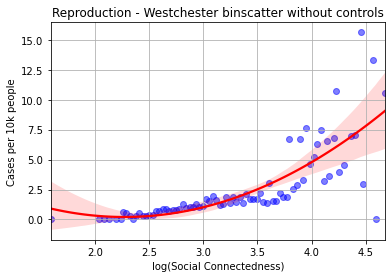

In [40]:
# plot binscatter with quadratic trend and 95% ci
sns.regplot(x=us_sci_covariates.groupby(bins).mean()[['log_sci']], 
            y=us_sci_covariates.groupby(bins).mean()[['cases_per_10k']], 
            scatter_kws={'alpha':0.5, 'color':'blue'}, 
            line_kws={'color':'red'}, 
            order=2)

plt.ylabel('Cases per 10k people')
plt.xlabel('log(Social Connectedness)')
plt.title('Reproduction - Westchester binscatter without controls')
plt.grid()
plt.show()

### US Data - with controls

"... we first regress log(SCI) and cases per 10,000 residents on a set of control variables and plot the residualized values on each axis. Red lines show quadratic fit regressions. The controls for Panel (d) are 100 dummies for the percentile of the county’s geographic distance to Westchester; population density; median household income; and dummies for the six National Center for Health Statistics Urban-Rural county classifications."

In [41]:
# select variables of interest
us_sci_covariates_controls = us_sci_covariates[['log_sci', 
                                                'cases_per_10k', 
                                                'dist', 
                                                'med_hhinc2016', 
                                                'urban_rural_code', 
                                                'popdensity2010']]

In [42]:
# selection result
us_sci_covariates_controls.head()

,log_sci,cases_per_10k,dist,med_hhinc2016,urban_rural_code,popdensity2010
0,4.679882,10.547996,61.112783,61863.29358,4,162.326520
1,4.597618,0.000000,187.561703,88977.23791,6,226.190220
2,4.564192,13.327527,65.738824,51741.82243,6,80.099533
3,4.482016,5.855468,75.903426,61497.91792,5,99.409966
4,4.465725,0.000000,158.881360,63389.85032,5,160.151470


In [43]:
# create 'percentile' column for us counties
quantiles = np.arange(0.0, 1.0, 0.01)
us_sci_covariates_controls['percentile'] = np.nan
for q in quantiles:
    us_sci_covariates_controls.loc[(us_sci_covariates_controls['dist'] >= 
                                    np.quantile(us_sci_covariates_controls['dist'].values, q)) & 
                                   (us_sci_covariates_controls['dist'] < 
                                    np.quantile(us_sci_covariates_controls['dist'].values, q+0.01)), 
                                   ['percentile']] = q+0.01

In [44]:
# get dummies
dist_dummies = pd.get_dummies(data=us_sci_covariates_controls['percentile'], prefix='dist')
urban_dummies = pd.get_dummies(data=us_sci_covariates_controls['urban_rural_code'], prefix='urban')

In [45]:
# concatenate dummies with the main DataFrame
us_sci_covariates_controls = pd.concat([us_sci_covariates_controls.drop(['dist', 
                                                                         'urban_rural_code', 
                                                                         'percentile'], axis=1), 
                                        dist_dummies, 
                                        urban_dummies], axis=1)

In [46]:
# resulting DataFrame with dummies
us_sci_covariates_controls.head()

,log_sci,cases_per_10k,med_hhinc2016,popdensity2010,dist_0.01,dist_0.02,dist_0.03,dist_0.04,dist_0.05,dist_0.060000000000000005,...,dist_0.97,dist_0.98,dist_0.99,dist_1.0,urban_1,urban_2,urban_3,urban_4,urban_5,urban_6
0,4.679882,10.547996,61863.29358,162.326520,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,4.597618,0.000000,88977.23791,226.190220,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4.564192,13.327527,51741.82243,80.099533,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4.482016,5.855468,61497.91792,99.409966,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,4.465725,0.000000,63389.85032,160.151470,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [47]:
# OLS
# target variables
y1 = us_sci_covariates_controls['log_sci'].values
y2 = us_sci_covariates_controls['cases_per_10k'].values
# explanatory variables (RHS non constant)
x = us_sci_covariates_controls.iloc[:, 2:].values
X = sm.add_constant(x) # adding constant

In [48]:
# get residuals for SCI
results_log_sci = sm.OLS(y1, X).fit()
log_sci_resid = results_log_sci.resid
# get residuals for Cases
results_cases_per_10k = sm.OLS(y2, X).fit()
cases_per_10k_resid = results_cases_per_10k.resid

In [49]:
# construct DataFrame with residuals
resid_df = pd.DataFrame()
resid_df['log_sci_resid'] = log_sci_resid
resid_df['cases_per_10k_resid'] = cases_per_10k_resid
resid_df['log_sci'] = us_sci_covariates_controls['log_sci']

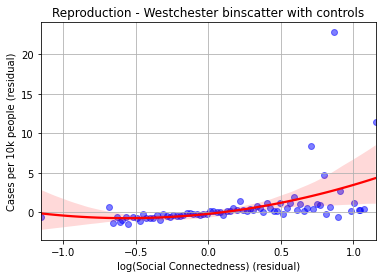

In [50]:
# group log(SCI) residual into 100 equal-sized bins and plot binscatters
bins_resid = pd.cut(x=resid_df['log_sci_resid'], bins=100, precision=3)

sns.regplot(x=resid_df.groupby(bins_resid).mean()[['log_sci_resid']], 
            y=resid_df.groupby(bins_resid).mean()[['cases_per_10k_resid']], 
            scatter_kws={'alpha':0.5, 'color':'blue'}, 
            line_kws={'color':'red'}, 
            order=2)

plt.ylabel('Cases per 10k people (residual)')
plt.xlabel('log(Social Connectedness) (residual)')
plt.title('Reproduction - Westchester binscatter with controls')
plt.grid()
plt.show()

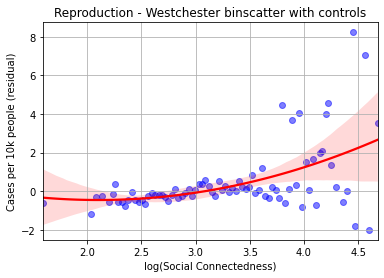

In [51]:
# group log(SCI) into 100 equal-sized bins and plot binscatters
bins_resid = pd.cut(x=resid_df['log_sci'], bins=100, precision=3)

sns.regplot(x=resid_df.groupby(bins_resid).mean()[['log_sci']], 
            y=resid_df.groupby(bins_resid).mean()[['cases_per_10k_resid']], 
            scatter_kws={'alpha':0.5, 'color':'blue'}, 
            line_kws={'color':'red'}, 
            order=2)

plt.ylabel('Cases per 10k people (residual)')
plt.xlabel('log(Social Connectedness)')
plt.title('Reproduction - Westchester binscatter with controls')
plt.grid()
plt.show()

### Italy data - no controls

In [19]:
# load SCI data
it_sci_covariates = pd.read_csv('covid19_exploration/_intermediate/lodi_sci_covariates.csv', 
                                encoding='cp1251')
# filter out close provinces
print(f'Old minimum distance to the early hotspot = {np.round(it_sci_covariates.dist.min())}')
it_sci_covariates = it_sci_covariates.loc[it_sci_covariates['dist'] > 50.0]
print(f'New minimum distance to the early hotspot = {np.round(it_sci_covariates.dist.min())}')
# sort observations
it_sci_covariates = it_sci_covariates.sort_values(by='sci', ascending=False).reset_index(drop=True)
# take logs of SCI
it_sci_covariates['log_sci'] = np.log(it_sci_covariates['sci'])

Old minimum distance to the early hotspot = 0.0
New minimum distance to the early hotspot = 51.0


In [20]:
# top 10 Italian provinces by SCI to Lodi (distance to the hotspot > 50 miles)
it_sci_covariates[['nuts3_code', 'sci', 'cases_per_10k', 'dist']].head(10)

,nuts3_code,sci,cases_per_10k,dist
0,ITC46,47798.0,77.981342,64.965373
1,ITC4D,42647.0,27.096540,50.662781
2,ITC44,39248.0,24.586142,121.257001
3,ITC43,36104.0,42.341419,76.147999
4,ITI11,35345.0,27.725442,113.739006
5,ITC32,35315.0,8.962960,146.866527
6,ITH52,34707.0,41.287623,72.475284
7,ITH59,33824.0,40.969392,269.163430
8,ITC47,33720.0,65.058515,77.587660
9,ITC41,30620.0,9.724568,89.505414


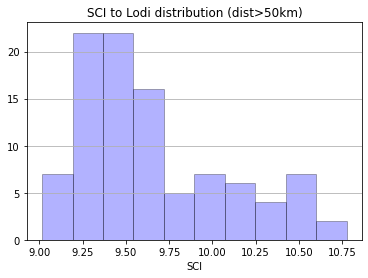

In [22]:
# distribution of SCI to Lodi across Italian provinces
plt.hist(it_sci_covariates['log_sci'], bins=10, color='blue', alpha=0.3, ec='black')
plt.grid(axis='y')
plt.title('SCI to Lodi distribution (dist>50km)')
plt.xlabel('SCI')
plt.show()

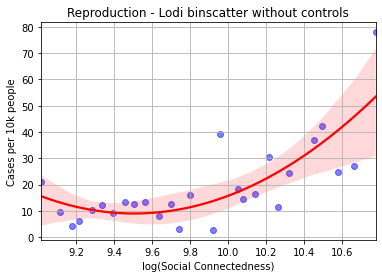

In [23]:
# group log(SCI) into 30 equal-sized bins and plot binscatters
bins = pd.cut(x=it_sci_covariates['log_sci'], bins=30, precision=3)

sns.regplot(x=it_sci_covariates.groupby(bins).mean()[['log_sci']], 
            y=it_sci_covariates.groupby(bins).mean()[['cases_per_10k']], 
            scatter_kws={'alpha':0.5, 'color':'blue'}, 
            line_kws={'color':'red'}, 
            order=2)

plt.ylabel('Cases per 10k people')
plt.xlabel('log(Social Connectedness)')
plt.title('Reproduction - Lodi binscatter without controls')
plt.grid()
plt.show()

### Italy data - with controls

"However, we first regress log(SCI) and cases per 10,000 residents on a set of control variables and plot the residualized values on each axis. Red lines show quadratic fit regressions. The controls for Panel (d) are 20 dummies for quantiles of the province’s geographic distance to Lodi; GDP per inhabitant; and population density."

In [24]:
# selevt variables of interest
it_sci_covariates_controls = it_sci_covariates[['log_sci', 
                                                 'cases_per_10k', 
                                                 'dist', 
                                                 'gdp_per_hab', 
                                                 'pop_per_km']]

In [25]:
# resulting dataframe
it_sci_covariates_controls.head()

,log_sci,cases_per_10k,dist,gdp_per_hab,pop_per_km
0,10.774739,77.981342,64.965373,32700,410.6
1,10.660712,27.096540,50.662781,30600,2160.4
2,10.577656,24.586142,121.257001,29200,57.4
3,10.494159,42.341419,76.147999,30800,459.1
4,10.472912,27.725442,113.739006,24700,169.3


In [26]:
# create 'percentile' column for us counties
quantiles = np.arange(0.0, 1.0, 0.05)
it_sci_covariates_controls['percentile'] = np.nan
for q in quantiles:
    it_sci_covariates_controls.loc[(it_sci_covariates_controls['dist'] >= 
                                    np.quantile(it_sci_covariates_controls['dist'].values, q)) & 
                                   (it_sci_covariates_controls['dist'] < 
                                    np.quantile(it_sci_covariates_controls['dist'].values, q+0.05)), 
                                   ['percentile']] = q+0.05

In [27]:
# get dummies
dist_dummies = pd.get_dummies(data=it_sci_covariates_controls['percentile'], prefix='dist')

In [28]:
# concatenate main DataFrame and dummies
it_sci_covariates_controls = pd.concat([it_sci_covariates_controls.drop(['dist', 
                                                                         'percentile'], axis=1), 
                                        dist_dummies], axis=1)

In [29]:
# resulting dataframe with dummies
it_sci_covariates_controls.head()

,log_sci,cases_per_10k,gdp_per_hab,pop_per_km,dist_0.05,dist_0.1,dist_0.15000000000000002,dist_0.2,dist_0.25,dist_0.3,...,dist_0.55,dist_0.6000000000000001,dist_0.6500000000000001,dist_0.7000000000000001,dist_0.7500000000000001,dist_0.8,dist_0.8500000000000001,dist_0.9000000000000001,dist_0.9500000000000001,dist_1.0
0,10.774739,77.981342,32700,410.6,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10.660712,27.096540,30600,2160.4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10.577656,24.586142,29200,57.4,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10.494159,42.341419,30800,459.1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10.472912,27.725442,24700,169.3,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# get residuals of OLS

# target variables
y1 = it_sci_covariates_controls['log_sci'].values
y2 = it_sci_covariates_controls['cases_per_10k'].values
# explanatory variables (RHS non constant)
x = it_sci_covariates_controls.iloc[:, 2:].values
X = sm.add_constant(x) # adding constant
# get OLS residuals for SCI
results_log_sci = sm.OLS(y1, X).fit()
log_sci_resid = results_log_sci.resid
# get OLS residuals for Cases
results_cases_per_10k = sm.OLS(y2, X).fit()
cases_per_10k_resid = results_cases_per_10k.resid
# form a DataFrame with residuals
it_resid_df = pd.DataFrame()
it_resid_df['log_sci_resid'] = log_sci_resid
it_resid_df['cases_per_10k_resid'] = cases_per_10k_resid
it_resid_df['log_sci'] = it_sci_covariates_controls['log_sci']

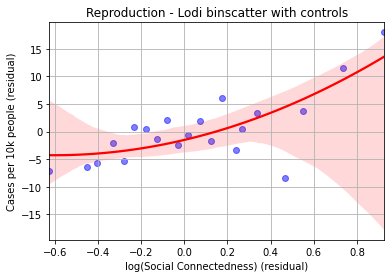

In [31]:
# group log(SCI) residual into 30 equal-sized bins and plot binscatters
bins_resid = pd.cut(x=it_resid_df['log_sci_resid'], bins=30, precision=3)

sns.regplot(x=it_resid_df.groupby(bins_resid).mean()[['log_sci_resid']], 
            y=it_resid_df.groupby(bins_resid).mean()[['cases_per_10k_resid']], 
            scatter_kws={'alpha':0.5, 'color':'blue'}, 
            line_kws={'color':'red'}, 
            order=2)

plt.ylabel('Cases per 10k people (residual)')
plt.xlabel('log(Social Connectedness) (residual)')
plt.title('Reproduction - Lodi binscatter with controls')
plt.grid()
plt.show()

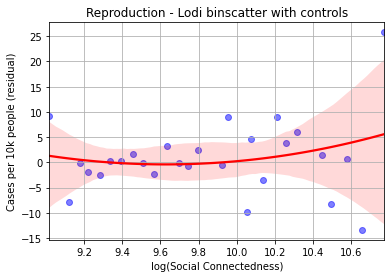

In [32]:
# group log(SCI) into 30 equal-sized bins and plot binscatters
bins_resid = pd.cut(x=it_resid_df['log_sci'], bins=30, precision=3)

sns.regplot(x=it_resid_df.groupby(bins_resid).mean()[['log_sci']], 
            y=it_resid_df.groupby(bins_resid).mean()[['cases_per_10k_resid']], 
            scatter_kws={'alpha':0.5, 'color':'blue'}, 
            line_kws={'color':'red'}, 
            order=2)

plt.ylabel('Cases per 10k people (residual)')
plt.xlabel('log(Social Connectedness)')
plt.title('Reproduction - Lodi binscatter with controls')
plt.grid()
plt.show()